In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import chess
import chess.engine
import matplotlib.pyplot as plt
from IPython import display

import warnings
warnings.filterwarnings('ignore')

In [79]:
# def random_board(max_depth=200):
#     board = chess.Board()
#     depth = random.randrange(0, max_depth)

#     for _ in range(1):
#         all_moves = list(board.legal_moves)
#         random_move = random.choice(all_moves)
#         board.push(random_move)
#         if board.is_game_over():
#             break
        
#     return board

# board = random_board()
# board

In [80]:
class ChessNN(nn.Module):
    def __init__(self):
        super(ChessNN, self).__init__()
        self.fc1 = nn.Linear(64 * 12, 256)  # Assuming a simple one-hot encoding of the board
        self.fc2 = nn.Linear(256, 64 * 64)  # Outputting one value for each possible move (simplified)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [81]:
def board_to_tensor(board):
    board_tensor = np.zeros((12, 8, 8), dtype=np.float32)
    piece_to_idx = {'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5,
                    'P': 6, 'N': 7, 'B': 8, 'R': 9, 'Q': 10, 'K': 11}
    for i in range(64):
        piece = board.piece_at(i)
        if piece is not None:
            piece_idx = piece_to_idx.get(piece.symbol(), -1)
            if piece_idx != -1:
                row, col = divmod(i, 8)
                board_tensor[piece_idx, row, col] = 1
    return board_tensor.flatten()


In [82]:
def select_move(model, board, epsilon=0.2):
    legal_moves = list(board.legal_moves)
    if random.random() < epsilon:  # Exploration
        return random.choice(legal_moves)
    else:  # Exploitation
        board_tensor = torch.FloatTensor([board_to_tensor(board)])
        with torch.no_grad():
            predictions = model(board_tensor).view(64, 64)
        move_scores = {}
        for move in legal_moves:
            move_scores[move] = predictions[move.from_square, move.to_square]
        best_move = max(move_scores, key=move_scores.get)
        return best_move


In [83]:
def get_move_reward(board, move):
    reward = 0
    if board.is_capture(move):
        captured_piece = board.piece_at(move.to_square)
        piece_value = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0.1}
        reward += piece_value.get(captured_piece.symbol().upper(), 0)

    # Additional rewards/penalties could be added here based on strategic positions etc.
    return reward

def get_game_reward(result):
    # Defines reward based on the game result
    if result == "1-0":  # White wins
        return 1
    elif result == "0-1":  # Black wins
        return -1
    else:  # Draw
        return 0

In [84]:
def plot_training(losses, outcomes, white_scores, black_scores, window=10):
    plt.figure(figsize=(18, 3))
    
    # Smoothed losses
    smoothed_losses = np.convolve(losses, np.ones(window) / window, mode='valid')

    plt.subplot(1, 3, 1)
    # plt.plot(losses, label='Loss')
    plt.plot(smoothed_losses, label='Loss (smoothed)')
    plt.title('Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    wins = [outcome == '1-0' for outcome in outcomes]
    losses = [outcome == '0-1' for outcome in outcomes]
    draws = [outcome == '1/2-1/2' for outcome in outcomes]
    plt.plot(wins, label='Wins', color='g')
    plt.plot(losses, label='Losses', color='r')
    plt.plot(draws, label='Draws', color='b')
    plt.title('Game Outcomes')
    plt.xlabel('Episode')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(white_scores, label='White Score', color='lightblue')
    plt.plot(black_scores, label='Black Score', color='gray')
    plt.title('Score Tracking by Player')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()

    # Optionally, add a subplot for move origins if summarized data is available
    # This would typically be a count of NN vs. random moves per episode
    # plt.subplot(1, 4, 4)
    # Plot move origin data here

    display.clear_output(wait=True)
    display.display(plt.gcf())


In [85]:
def train_model(model, optimizer, episodes=50, gamma=0.9):
    loss_fn = torch.nn.MSELoss()
    data = []  # List to collect data dictionaries

    for episode in range(episodes):
        board = chess.Board()
        game_history = []
        episode_moves = []
        white_score = 0
        black_score = 0
        move_origins = []  # List to track move origins

        while not board.is_game_over():
            epsilon = max(0.1, 1 - episode / episodes)  # Decrease epsilon over episodes
            move_type = "random" if random.random() < epsilon else "NN"
            move = select_move(model, board, epsilon)
            if not move:  # If no valid move, break the loop
                break
            board.push(move)
            game_state = board_to_tensor(board)
            game_history.append((game_state, move))
            move_origin = {
                "move": move.uci(),
                "type": move_type,
                "player": 'White' if board.turn == chess.BLACK else 'Black'
            }
            move_origins.append(move_origin)
            move_reward = get_move_reward(board, move)
            if board.turn == chess.BLACK:  # White made the move
                white_score += move_reward
            else:
                black_score += move_reward
            episode_moves.append((move.uci(), move_origin['player']))

        result = board.result()
        reward = get_game_reward(result)
        total_loss = 0

        for state, move in reversed(game_history):
            current_state_tensor = torch.FloatTensor([state])
            target_reward = torch.tensor([reward], dtype=torch.float32)
            predicted_reward = model(current_state_tensor)
            loss = loss_fn(predicted_reward, target_reward)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            reward = reward * gamma
            total_loss += loss.item()

        # Save episode data to list
        data.append({
            "Episode": episode + 1,
            "Loss": total_loss,
            "Result": result,
            "Winner": 'White' if result == '1-0' else 'Black' if result == '0-1' else 'Draw',
            "White Score": white_score,
            "Black Score": black_score,
            "Moves": ', '.join([f"{m[1]}: {m[0]}" for m in episode_moves]),
            "Move Origins": move_origins
        })
        
        # Plot training with separate scores for white and black
        # if episode % 10 == 0 or episode == episodes - 1:
        plot_training([d['Loss'] for d in data], 
                      [d['Result'] for d in data], 
                      [d['White Score'] for d in data], 
                      [d['Black Score'] for d in data])

        move_details = ', '.join([f"{m['player']}: {m['move']} ({m['type']})" for m in move_origins])
        print(f"Episode {episode + 1}: Loss = {total_loss:.4f}, Result = {result}, Moves = {move_details}")

    plt.ioff()  # Turn off the interactive mode
    plt.show()  # Ensure the last plot remains

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(data)
    return df


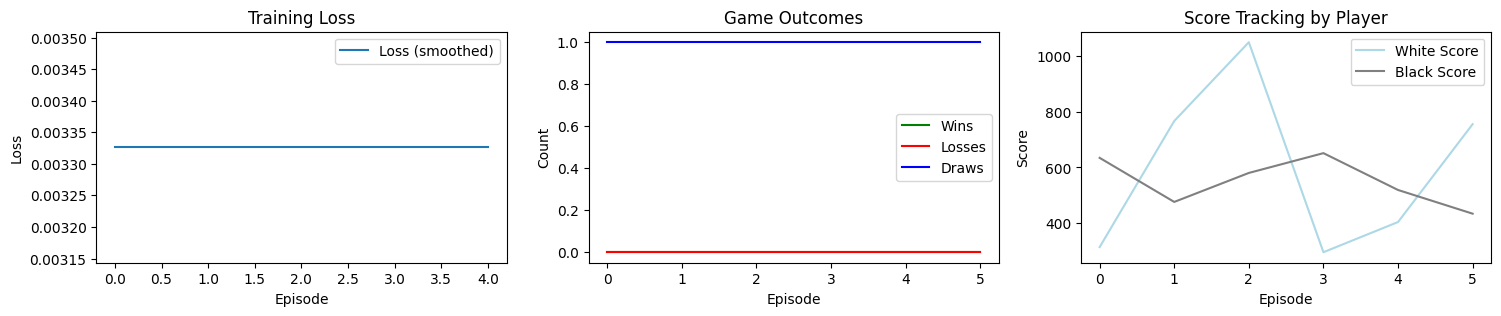

Episode 6: Loss = 0.0002, Result = 1/2-1/2, Moves = White: g2g4 (random), Black: h7h6 (random), White: g1h3 (random), Black: h8h7 (random), White: c2c4 (random), Black: a7a5 (random), White: f1g2 (random), Black: a8a6 (random), White: e2e3 (random), Black: g8f6 (random), White: e1e2 (random), Black: f6e4 (random), White: d1a4 (random), Black: e4c3 (random), White: b2c3 (NN), Black: a6a8 (NN), White: g2e4 (random), Black: h6h5 (random), White: g4h5 (random), Black: b8c6 (random), White: e4h7 (random), Black: c6e5 (random), White: e2d1 (random), Black: e5d3 (random), White: d1e2 (random), Black: a8b8 (random), White: b1a3 (random), Black: d3c1 (random), White: e2d1 (random), Black: b8a8 (random), White: f2f4 (random), Black: c1b3 (random), White: d1e2 (random), Black: b7b6 (random), White: d2d4 (random), Black: b6b5 (random), White: h7g6 (random), Black: e7e6 (random), White: a1f1 (random), Black: d7d5 (random), White: e2d1 (random), Black: d8e7 (NN), White: e3e4 (random), Black: b3d2 (r

In [86]:
model = ChessNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
results = train_model(model, optimizer, episodes=100)


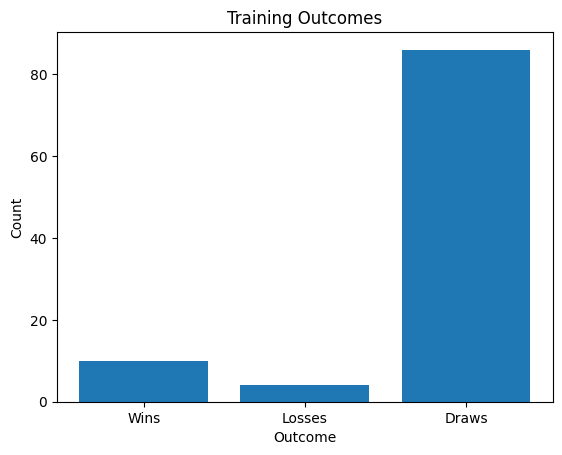

In [ ]:
import matplotlib.pyplot as plt

# Assuming `results` holds the win/draw/loss outcomes
win_counts = sum(1 for result in results if result == '1-0')
loss_counts = sum(1 for result in results if result == '0-1')
draw_counts = len(results) - win_counts - loss_counts

plt.bar(['Wins', 'Losses', 'Draws'], [win_counts, loss_counts, draw_counts])
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Training Outcomes')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'chess_model.pth')
print("Model saved successfully.")


Model saved successfully.


In [ ]:
model = ChessNN()
model.load_state_dict(torch.load('chess_model.pth'))
model.eval()
print("Model loaded and set to evaluation mode.")


Model loaded and set to evaluation mode.


In [ ]:
def watch_model_play(model):
    board = chess.Board()
    while not board.is_game_over():
        move = select_move(model, board, epsilon=0)  # Always use the model's choice
        board.push(move)
        print("Move:", move.uci())
        print("White to move" if board.turn else "Black to move")
        print(board)
        print("\n")
    print(f"Game result: {board.result()}")  # '1-0' (White wins), '0-1' (Black wins), '1/2-1/2' (Draw)


watch_model_play(model)


Move: g1h3
Black to move
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . N
P P P P P P P P
R N B Q K B . R


Move: f7f6
White to move
r n b q k b n r
p p p p p . p p
. . . . . p . .
. . . . . . . .
. . . . . . . .
. . . . . . . N
P P P P P P P P
R N B Q K B . R


Move: h1g1
Black to move
r n b q k b n r
p p p p p . p p
. . . . . p . .
. . . . . . . .
. . . . . . . .
. . . . . . . N
P P P P P P P P
R N B Q K B R .


Move: d7d6
White to move
r n b q k b n r
p p p . p . p p
. . . p . p . .
. . . . . . . .
. . . . . . . .
. . . . . . . N
P P P P P P P P
R N B Q K B R .


Move: g1h1
Black to move
r n b q k b n r
p p p . p . p p
. . . p . p . .
. . . . . . . .
. . . . . . . .
. . . . . . . N
P P P P P P P P
R N B Q K B . R


Move: c8e6
White to move
r n . q k b n r
p p p . p . p p
. . . p b p . .
. . . . . . . .
. . . . . . . .
. . . . . . . N
P P P P P P P P
R N B Q K B . R


Move: h1g1
Black to move
r n . q k b n r
p p p . p . p p
. . . p b p .